# Predicting Heart Disease with Logistic Regression

Analysis Performed and reported by David Schwab (*dvschwab@protonmail.com*)

* LinkedIN:  www.linkedin.com/in/david-v-schwab
* github:    https://github.com/dvschwab

This notebook estimates a set of logistic regression models to predict the presence of heart disease from a publically-available data set. The full model has 13 features, while each of two reduced models have 9. In each case, the target is the presence or absence of heart disease, encoded a either 0 (absence) or 1 (presence).

The data used in the experiment was downloaded from https://www.kaggle.com/ronitf/heart-disease-uci on January 1, 2021. Certain cases have been either excluded or recoded based on comments from the data set's discussion forum (see **1.3 Data Description**). No other alterations were made.

**This analysis was not reviewed by any medical professionals and should not be relied upon for any medical purpose**.

## Preliminaries

Here, we import the required modules (including the stats_function module containing our user-defined functions), configure the output window, and load the data.

In [1]:
import csv
import collections          # For OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [2]:
# set the output precision to 2 decimal places for pandas and numpy
# and the line width for numpy to 300 chars.

pd.set_option('precision', 2)
pd.options.display.float_format = '{:20,.2f}'.format
np.set_printoptions(linewidth = 300, suppress=True, formatter={'float': lambda x: "{0:10.2f}".format(x)})

In [3]:
# Load the heart disease data from a csv file into a pandas Data Frame

path = "C:/Users/dvschwab/Documents/Programming/Python3/Data Sets/heart.csv"

df_heart = pd.read_csv(path)

## User-Defined Functions

A simple function for identifying outliers using the IQR.

In [4]:
# simple function to return an outlier range as some multiple of the IQR
# both 1.5 and 3 are common choices

def iqr_outliers(values, multiplier = 1.5):
    """Return a two-element list of low and high outlier cutoffs for the array-like parameter values.
       Both values are calculated as a multiple of the median value +/- the interquartile range (IQR),
       which is not dependent on the distribution having a certain form.
       
       Parameters:
           values: an array-like object containing two or more elements and all elements numeric
           multiplier: any positive number, typically between 1.5 and 3"""
    
    # check if values is a single-dimensional object (e.g. array, Series, etc.)
    # check if multiplier is positive
    
    assert np.ndim(values) == 1, "parameter *values* has dimension other than 1"
    assert multiplier > 0, "parameter *multiplier should not be zero or negative"
        
    try:
        median_value = values.median()
        iqr = (values.quantile(.75) - values.quantile(.25))
        assert iqr > 0, "IQR should not be negative"
        
        outlier_low = median_value - (multiplier * iqr)
        outlier_high = median_value + (multiplier * iqr)
        
        assert (outlier_low <= median_value <= outlier_high), "one of outlier_low, median_value, or outlier_high is out of range"
        
        return [outlier_low, outlier_high]
    
    except TypeError as err:
        print("TypeError")
    except AttributeError as err:
        print("AttributeError: {0}".format(err))

## Data Description

This data set has features that may predict heart disease. The features are some basic demographics (e.g. age, sex) and several medical data points, such as resting blood pressure and cholesteral. The target feature (named *target*) is whether the patient presents with heart disease: note that **0=disease** and **1=no disease**, contrary to what you might think (however, this is recoded below to the standard values).

The demographic features are self-explanatory (note that for sex, 1= male). Here are descriptions of the medical data points. This is taken from the guide provided at https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877, accessed Jan. 1, 2021.

### Dropped Rows

According to that URL, rows containing *ca = 4* or *thal = 0* are data errors and should have those values set to NaN. Instead, we will just drop them. The following rows will be excluded:

* 48, 92, 158, 163, 164, 251, 281

### Description of Medical Data Points

These are the categorical data points and their descriptions

* cp: chest pain type:
    * 0: asymptomatic (no pain)
    * 1: atypical angina
    * 2: non-anginal pain
    * 3: typical angina
* fbs: fasting blood sugar > 120 mg/dl (True or False)
    * 0: False
    * 1: True
* restecg: resting electrocardiograph results
    * 0: showing probable or definite left ventricular hypertrophy
    * 1: normal
    * 2: having ST-T wave abnormality
* exang: exercise induced angina (True or False)
    * 0: False
    * 1: True
* slope: the slope of the peak exercise ST segment
    * 0: downsloping
    * 1: flat
    * 2: upsloping
* thal: this refers to a certain type of heart defect; "thal" stands for "thalium", which is the radioactive tracer used to detect this type of defect.
    * 1: fixed defect
    * 2: normal
    * 3: reversable defect

These are the continuous data points and their descriptions:

* trestbps: resting blood pressure
* chol: serum cholestoral in mg/dl
* thalach: maximum heart rate achieved (not sure why they chose this name)
* oldpeak: ST depression induced by exercise relative to rest
* ca: number of major vessels colored by flouroscopy (0 - 4)

### Renamed Columns

Since a few of the columns have names that aren't very descriptive, we will rename them. Here are the mappings:

* cp -> chest_pain
* trestbps -> rest_bp
* fbs -> blood_sugar
* thalach -> max_heart_rate
* exang -> angina
* slope -> ST_slope
* ca -> flouroscopy
* thal -> heart_defect
* target -> heart_disease

### Recoded Data Points

Since the coding on a few of the medical data points is inconsistent, we'll recode them so that in all cases 0 indicates either normal behavior or the absence of disease. To make the analysis more straightforward, we will also combine the relatively few data points in categories 2 and 3 into category 1.

* restecg -> {0: 1, 1: 0, 2: 1}
* heart-defect -> {2: 0, 1: 1, 3: 1}
* ST_slope -> {0: 1, 1: 0, 2: 1}
* chest_pain -> {0: 0, 1: 1, 2: 1, 3: 1}
* flouroscopy -> {0: 1, 1: 1, 2: 1, 3: 1}
* heart_disease -> {0: 1, 1: 0}

This updates the decoded values given above for the *restecg*, *heart_disease*, and other variables. Most importantly, *heart_disease*, which is the predicted target, is now coded **0=no disease** and **1=disease**, the opposite of the raw data set.

### Excluding Rows with Invalid Observations

In [5]:
# Rows to exclude because ca = 4

df_heart[(df_heart.ca == 4)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
92,52,1,2,138,223,0,1,169,0,0.00,2,4,2,1
158,58,1,1,125,220,0,1,144,0,0.40,1,4,3,1
163,38,1,2,138,175,0,1,173,0,0.00,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.00,2,4,2,1
251,43,1,0,132,247,1,0,143,1,0.10,1,4,3,0


In [6]:
# Rows to exclude because thal = 0

df_heart[(df_heart.thal == 0)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
48,53,0,2,128,216,0,0,115,0,0.00,2,0,0,1
281,52,1,0,128,204,1,1,156,1,1.00,1,0,0,0


In [7]:
# This displays the rows to be dropped and the next cell drops them.

rows_to_drop = [48, 92, 158, 163, 164, 251, 281]

df_heart.iloc[rows_to_drop]


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
48,53,0,2,128,216,0,0,115,0,0.00,2,0,0,1
92,52,1,2,138,223,0,1,169,0,0.00,2,4,2,1
158,58,1,1,125,220,0,1,144,0,0.40,1,4,3,1
163,38,1,2,138,175,0,1,173,0,0.00,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.00,2,4,2,1
251,43,1,0,132,247,1,0,143,1,0.10,1,4,3,0
281,52,1,0,128,204,1,1,156,1,1.00,1,0,0,0


In [8]:
df_heart_working = df_heart[~df_heart.index.isin(rows_to_drop)].copy()

### Renaming Columns

In [9]:
# This renames the columns

column_dict = {
    'cp': 'chest_pain',
    'trestbps': 'rest_bp',
    'fbs': 'blood_sugar',
    'thalach': 'max_heart_rate',
    'exang': 'angina',
    'slope': 'ST_slope',
    'ca': 'flouroscopy',
    'thal': 'heart_defect',
    'target': 'heart_disease'
}

df_heart_working = df_heart_working.rename(columns = column_dict)

### Recoding Variables

In [10]:
# This recodes the restecg, heart_defect, and heart_disease data points

recoding_dict = {
    'restecg': {0: 1, 1: 0, 2: 1},
    'heart_defect': {2: 0, 1: 1, 3: 1},
    'heart_disease': {0: 1, 1: 0},
    'ST_slope': {0: 1, 1: 0, 2: 1},
    'chest_pain': {0: 0, 1: 1, 2: 1, 3: 1},
    'flouroscopy': {0: 0, 1: 1, 2: 1, 3: 1},
}

df_heart_working.replace(recoding_dict, inplace=True)

In [11]:
# reset the index since rows have been removed

df_heart_working.reset_index(drop=True, inplace=True)

### Updated Data Set

Here is the updated data set with the selected rows excluded, renamed columns, and all categorical variables recoded so that 0 always signifies either a normal result or the lack of a disease marker. The index has also been reset to be contiguous after dropping the rows.

There are 14 variables and 296 cases. Of these, the *age* and *sex* variables provide basic demographic information, while the remaining variables encode different medical data points. All variables except for *oldpeak* are stored as 64-bit numpy integers, while *oldpeak* is stored as a float.

In [12]:
df_heart_working.head()

,age,sex,chest_pain,rest_bp,chol,blood_sugar,restecg,max_heart_rate,angina,oldpeak,ST_slope,flouroscopy,heart_defect,heart_disease
0,63,1,1,145,233,1,1,150,0,2.30,1,0,1,0
1,37,1,1,130,250,0,0,187,0,3.50,1,0,0,0
2,41,0,1,130,204,0,1,172,0,1.40,1,0,0,0
3,56,1,1,120,236,0,0,178,0,0.80,1,0,0,0
4,57,0,0,120,354,0,0,163,1,0.60,1,0,0,0


In [13]:
# Here is our data set so far.
# We have 296 cases, all encoded as numpy int64 except for oldpeak,
# which is a float.

df_heart_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             296 non-null    int64  
 1   sex             296 non-null    int64  
 2   chest_pain      296 non-null    int64  
 3   rest_bp         296 non-null    int64  
 4   chol            296 non-null    int64  
 5   blood_sugar     296 non-null    int64  
 6   restecg         296 non-null    int64  
 7   max_heart_rate  296 non-null    int64  
 8   angina          296 non-null    int64  
 9   oldpeak         296 non-null    float64
 10  ST_slope        296 non-null    int64  
 11  flouroscopy     296 non-null    int64  
 12  heart_defect    296 non-null    int64  
 13  heart_disease   296 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.5 KB


## Exploratory Data Analysis

Having prepared the data, we now turn to its analysis. We start by reviewing descriptive statistics for each of the continuous variables, along with a pairwise-relationhip plot and correlation matrix. The goal is to find which variables have substantially different values when conditioned on the target variable, *heart_disease*. These variables are good predictor candidates. A secondary goal is to identify relationships between the continuous variables that may hinder the model by capturing similar information.

### Adding Scaled Variables

It is often helpful to scale continuous variables so that they each represent a similar range of values. Here, we have used the *StandardScaler* from the *sklearn* package to rescale each variable to a Z-score with zero mean and unit variance. The scaled column name is the unscaled name with "scaled" appended, and all scaled values are numpy 64-bit floats.

In [14]:
# scaled columns are (e.g) age -> age_scaled, etc.
cols = ['age', 'rest_bp', 'chol', 'max_heart_rate', 'oldpeak']
scaled_cols = [x + "_scaled" for x in cols]

scaler = StandardScaler()

# get the scaled values and generate a data frame, then
# join it to the df_heart_working data frame.

scaled_values = scaler.fit_transform(df_heart_working[cols])
scaled_df = pd.DataFrame(scaled_values, columns=scaled_cols, dtype=np.float64)
df_heart_scaled = df_heart_working.join(scaled_df).copy()

In [15]:
# Display the original and scaled columns

df_heart_scaled[cols + scaled_cols].head()

,age,rest_bp,chol,max_heart_rate,oldpeak,age_scaled,rest_bp_scaled,chol_scaled,max_heart_rate_scaled,oldpeak_scaled
0,63,145,233,150,2.30,0.94,0.76,-0.27,0.02,1.07
1,37,130,250,187,3.50,-1.94,-0.09,0.05,1.63,2.10
2,41,130,204,172,1.40,-1.50,-0.09,-0.83,0.98,0.29
3,56,120,236,178,0.80,0.16,-0.66,-0.21,1.24,-0.22
4,57,120,354,163,0.60,0.27,-0.66,2.06,0.59,-0.39


### Identifying Extreme Values

Next, we will identify continous variables with extreme values. These values will be flagged with a variable named *outlier* so that they can be identified.

The outlier bounds are returned by the user-defined *iqr_outliers()* function from the *stats_functions* module, which was imported at the start of the notebook. This method uses the median and interquartile range (IQR) to identify extreme values, which is robust to different types of distributions. The calculated values are:

    lower bound = (median - (n * IQR))
    upper bound = (median + (n * IQR))
    
The parameter n is typically 1.5 or 3; here, 1.5 is used.

In [16]:
# Note: the outliers are themselves a list [low, high], so this is a nested list

outliers = [iqr_outliers(df_heart_scaled[x], multiplier = 1.5) for x in cols]

# Display the outlier bounds

outliers_df = pd.DataFrame(outliers, index=cols, columns=['lower_bound', 'upper_bound'])
outliers_df

,lower_bound,upper_bound
age,36.50,75.50
rest_bp,100.00,160.00
chol,146.12,338.88
max_heart_rate,103.00,202.00
oldpeak,-1.68,3.28


In [17]:
# Create a new variable, "outliers", and set it
# to True if the row contains an outier or False otherwise.

outlier_indices = []

for i, column in enumerate(cols):
     
    low_bound, high_bound = outliers[i][0], outliers[i][1]
    outlier_rows = df_heart_scaled[column] < (low_bound or df_heart_scaled[column] > high_bound)
    outlier_indices.append(df_heart_scaled.loc[outlier_rows, column].index.to_list())

# This flattens the list, removing any sublists

outlier_indices = [item for sublist in outlier_indices for item in sublist]

# Now, create and populate the new variable

df_heart_scaled['outlier'] = False

for row in outlier_indices:
    df_heart_scaled.loc[row, 'outlier'] = True

In [18]:
# Display the identified outliers
# In all, 20 rows were identified, which is about 7% of the total (20 / 296)

df_heart_scaled[df_heart_scaled.outlier == True][cols]

,age,rest_bp,chol,max_heart_rate,oldpeak
52,44,108,141,175,0.60
57,34,118,182,174,0.00
64,35,138,183,182,1.40
70,51,94,227,154,0.00
71,29,130,204,202,0.00
109,57,150,126,173,0.20
122,39,94,199,179,0.00
123,34,118,210,192,0.70
134,60,120,178,96,0.00
155,35,122,192,174,0.00


### Descriptive Statistics

The descriptive statistics are, overall, unremarkable. With the exception of *oldpeak*, the data are at least approximately normal; this makes sense, given that these are gross medical measurements that are known to be distributed this way.

In [19]:
df_heart_working[cols].describe()

,age,rest_bp,chol,max_heart_rate,oldpeak
count,296.00,296.00,296.00,296.00,296.00
mean,54.52,131.60,247.16,149.56,1.06
std,9.06,17.73,51.98,22.97,1.17
min,29.00,94.00,126.00,71.00,0.00
25%,48.00,120.00,211.00,133.00,0.00
50%,56.00,130.00,242.50,152.50,0.80
75%,61.00,140.00,275.25,166.00,1.65
max,77.00,200.00,564.00,202.00,6.20


### Pairwise Plots of Continuous Variables

Here we have plotted a scatter plot of each pair of continous variables. The scaled variables are used and outliers are excluded so that the plots are easier to interpret. The marginal distributions are also plotted on the diagonal. For both types of plots, the cases with heart disease are displayed in orange, while the cases without heart disease are displayed in blue.

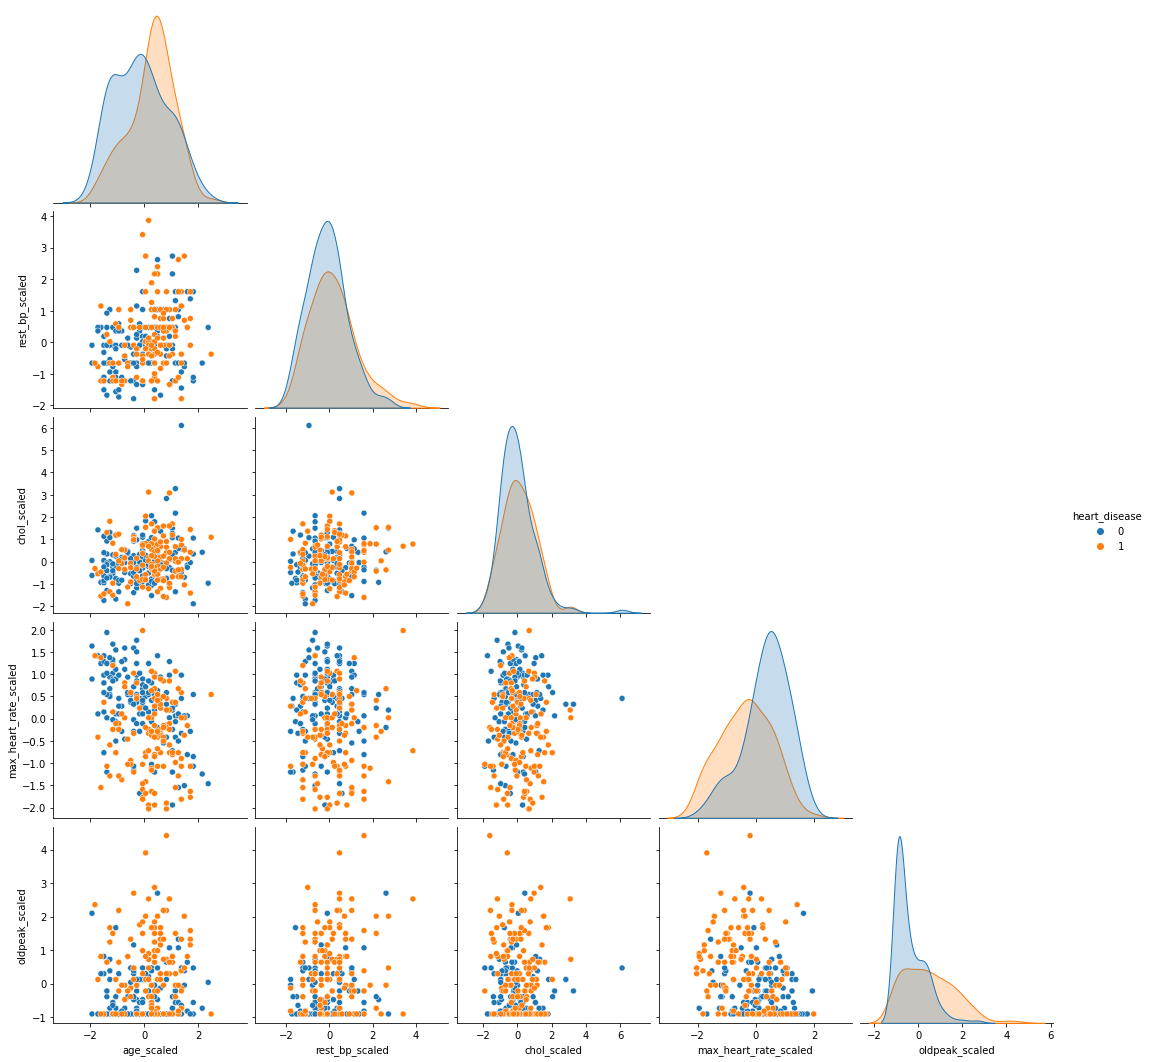

In [20]:
sns.pairplot(data=df_heart_scaled[df_heart_scaled.outlier == False], hue="heart_disease", kind='scatter', vars=scaled_cols, corner=True, height=3)

### Covariance and Correlation Matrices

The correlation matrice provides a numeric estimate of the linear relationship between the continuous variables. Overall, the correlations are minor: two exceptions are the correlation between age and maximum heart rate (-0.40) and between oldpeak and maximum heart rate (-0.35). In both cases, the pair plots show the expected relationship.

The heat map provides the same information as the correlation matrix, but encodes the values with contrasting colors to make them easier to interpret. Here we have explicitly set the maximum and minimum values for the color scale at (-1,1) and centered the scale on 0: positive correlations are progressively darker blue, while negative correlations are progressively lighter yellow.

In [21]:
cors = np.corrcoef(df_heart_scaled[cols], rowvar=False)
cors

array([[      1.00,       0.29,       0.20,      -0.40,       0.20],
       [      0.29,       1.00,       0.13,      -0.05,       0.20],
       [      0.20,       0.13,       1.00,      -0.00,       0.04],
       [     -0.40,      -0.05,      -0.00,       1.00,      -0.35],
       [      0.20,       0.20,       0.04,      -0.35,       1.00]])

<AxesSubplot:>

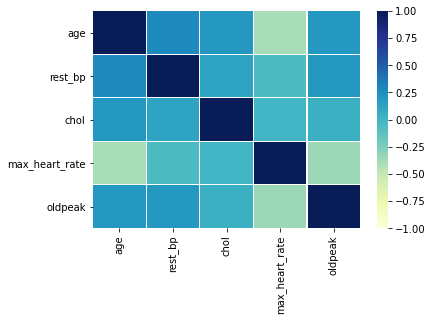

In [22]:
sns.heatmap(cors, vmin=-1, vmax=1, center=0, cmap="YlGnBu", linewidths = .25, xticklabels = cols, yticklabels=cols)

### Plots of Continuous Variables vs. Heart Disease

Plotting a boxplot of each continuous variable vs. heart disease to estimate the relationship. We overlay a stripplot to show the actual data values as well.

*Age*, *max_heart_rate*, and *oldpeak* show differences between heart disease and no disease; the other two variables show minor differences: these may be removed from the final model for parsimony and to help with overfitting.

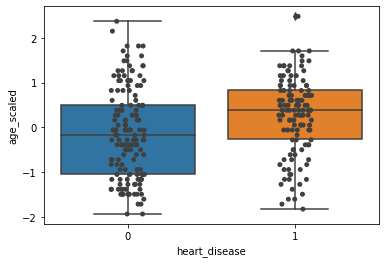

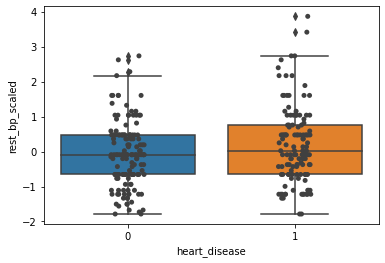

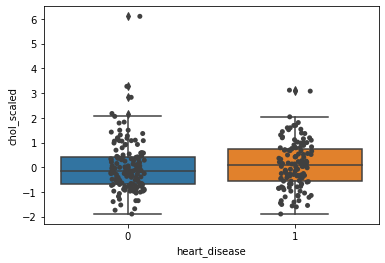

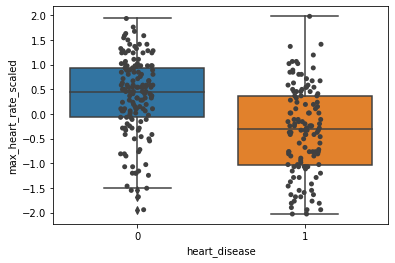

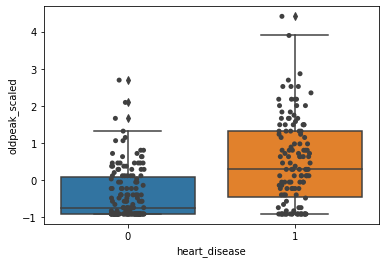

In [23]:
# Need to create separate figures so plots don't overwrite each other.

df = df_heart_scaled[df_heart_scaled.outlier == False]
for i, col in enumerate(df[scaled_cols]):
    plt.figure(i)
    sns.boxplot(x="heart_disease", y=col, data=df)
    sns.stripplot(x="heart_disease", y=col, data=df, color=".25")

### Crosstabs of Categorical Variables

To estimate the effect of each categorical variable on the target, we compute their cross-tabulations and estimate a chi-squared test of independence for each combination.

All except *blood_sugar* and *restecg* have very significant p-values (*restecg* is close to standard significance at 0.078, but with 8 simultaneous comparisons the expirement-wise cutoff is approx. 0.005).

In [24]:
# compute the cross-tabulation of each variable with heart_disease
# and estimate the chi-squared test of independence.

cat_columns = ['sex', 'chest_pain', 'blood_sugar', 'restecg', 'angina', 'ST_slope', 'flouroscopy','heart_defect']

for column in cat_columns:
    ctab = pd.crosstab(index=df_heart_scaled[column], columns=df_heart_scaled.heart_disease, margins=True)
    print("Crosstab of ", column, " with heart_disease")
    display(ctab)

    chi2, pvalue, dof, expected = chi2_contingency(ctab)

    print(f'chi-square:  {chi2:0.3f}')
    print(f'p-value: {pvalue:0.3f}')
    print(f'degrees of freedom: {dof}')
    print('\n')

Crosstab of  sex  with heart_disease


heart_disease,0,1,All
sex,,,
0,71,24,95
1,89,112,201
All,160,136,296


chi-square:  24.097
p-value: 0.000
degrees of freedom: 4


Crosstab of  chest_pain  with heart_disease


heart_disease,0,1,All
chest_pain,,,
0,39,102,141
1,121,34,155
All,160,136,296


chi-square:  75.532
p-value: 0.000
degrees of freedom: 4


Crosstab of  blood_sugar  with heart_disease


heart_disease,0,1,All
blood_sugar,,,
0,137,116,253
1,23,20,43
All,160,136,296


chi-square:  0.006
p-value: 1.000
degrees of freedom: 4


Crosstab of  restecg  with heart_disease


heart_disease,0,1,All
restecg,,,
0,92,55,147
1,68,81,149
All,160,136,296


chi-square:  8.557
p-value: 0.073
degrees of freedom: 4


Crosstab of  angina  with heart_disease


heart_disease,0,1,All
angina,,,
0,137,62,199
1,23,74,97
All,160,136,296


chi-square:  53.486
p-value: 0.000
degrees of freedom: 4


Crosstab of  ST_slope  with heart_disease


heart_disease,0,1,All
ST_slope,,,
0,48,89,137
1,112,47,159
All,160,136,296


chi-square:  37.141
p-value: 0.000
degrees of freedom: 4


Crosstab of  flouroscopy  with heart_disease


heart_disease,0,1,All
flouroscopy,,,
0,129,44,173
1,31,92,123
All,160,136,296


chi-square:  70.533
p-value: 0.000
degrees of freedom: 4


Crosstab of  heart_defect  with heart_disease


heart_disease,0,1,All
heart_defect,,,
0,127,36,163
1,33,100,133
All,160,136,296


chi-square:  83.156
p-value: 0.000
degrees of freedom: 4




## Logistic Regression Model

Having prepared and analyzed the data set, we now fit a logistic regression to predict the presence or absence of heart disease from these 13 predictors. Logistic regression is used both because it handles continuous and discrete data well, and because the coefficients possess some explanatory value as to the factors that are most important to prediction. Logistic regression can also estimate the predicted probability of a sample patient having heart disease, given values for the predictors: this in turn can estimate hazard rates for men vs. women, older vs. younger, and so on.

We will fit three different logistic regression models:

* Model 1: All predictors and all outliers
* Model 2: Reduced predictor set and all outliers
* Model 3: Reduced predictor set and no outliers

The reduced predictor set excludes the predictors *rest_bp*, *chol*, *blood_sugar*, and *restecg*. These are the 4 predictors that have the weakest relationship with the target variable *heart_disease*, as indicated above.

To make comparing the models easier, we'll define them as dictionaries and then evaluate them sequentially in a loop. We'll also define a dictionary of parameters for all three models so changes to these values can be easily made.

### Model Definitions

In [25]:
# Configure three logistic regression models

params = {
    'test_size': 0.3,
    'random_state': 823,
    'metrics': ['accuracy','neg_mean_squared_error'],
    'cv_splits': 5
}

model1 = {
    'model_name': 'clf_all',
    'columns': ["age", "sex", "chest_pain", "max_heart_rate", "angina", "oldpeak", "ST_slope", "flouroscopy", "heart_defect", "rest_bp", "chol", "blood_sugar", "restecg", "outlier"],
    'keep_outliers': True
}

model2 = {
    'model_name': 'clf_reduced',
    'columns': ["age", "sex", "chest_pain", "max_heart_rate", "angina", "oldpeak", "ST_slope", "flouroscopy", "heart_defect", "outlier"],
    'keep_outliers': True
}

model3 = {
    'model_name': 'clf_trimmed',
    'columns': ["age", "sex", "chest_pain", "max_heart_rate", "angina", "oldpeak", "ST_slope", "flouroscopy", "heart_defect", "outlier"],
    'keep_outliers': False
}


### Model Estimations

In [26]:
# Evaluate each model in turn

models = [model1, model2, model3]
clf = LogisticRegression(max_iter=1000)
df = df_heart_scaled.copy()
model_coef = collections.OrderedDict()            # Needed so order of columns in df matches insertion order

for model in models:
    
    # Keep or exclude outliers
    
    if (model['keep_outliers']):
        pass
    else:
        df = df[df.outlier == False]
    
    # Outlier column no longer needed, and will interfere with coef_df, below
    
    model['columns'].remove('outlier')
    
    # Define the model

    clf_cols = model['columns']
    X = df[clf_cols]
    y = df["heart_disease"]
    
    # Test-train split and accuracy scores
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = params['test_size'], shuffle = True, random_state=params['random_state'])
    log_regress = clf.fit(X_train, y_train)
    
    # Add results to model dictionary
    
    model['nbr_of_cases'] = len(df.index)
    model['train_accuracy'] = clf.score(X_train, y_train)
    model['test_accuracy'] = clf.score(X_test, y_test)
    
    # cross-validate with 5 folds and shuffling
    
    cross_val = KFold(n_splits = params['cv_splits'], shuffle = True, random_state = params['random_state'])
    model['cross_val_scores'] = cross_validate(clf, X, y, scoring=params['metrics'], cv=cross_val)
    
    # Add classification report

    model['predictions'] = clf.predict(X_test)
    model['y_test'] = y_test
    
    # Append coefficients to array and set to 'coef' key
    # flatten() needed since coef_ is nested array
    
    model['coef'] = np.array(log_regress.coef_.flatten())
    model_coef.update({
        model['model_name']: model['coef']})

### Model Summaries

Here are summaries of the accuracy and classification performance for each of the three models. The accuracy is how often the model correctly predicted the target, while the classification report provides more detail on whether the model overpredicts the target (precision) or underpredicts (recall). For each model, the accuracy and negative mean squared error (MSE) from a 5-fold cross validation are also reported.

Overall, the three models behave much the same: the greatest difference in accuracy scores across all models is between the train and test data for the *clf_reduced* model (0.86 and 0.82, respectively). The classification scores are also similar for both targets( *no disease* and *disease*), showing a slight tendency to better predict the presence of disease than its absence: the greatest difference here is for the *clf_trimmed* model, with an f1 score of 0.86 for the target *no disease* and 0.79 for the target *disease*. None of the three models show significant differences between precision and recall for either target. The 7% difference between the targets for the *clf_trimmed* model may be due to the removal of 20 outliers (7% of the total); this model also uses the reduced feature set containing 10 features rather than 14 for the *clf_all* model: depending on which features were more likely to contain outliers, this may also contribute to the observed difference. Further investigation of the outliers may confirm or reject this hypothesis.

The cross-validation scores show that all three models have a degree of sample dependency: the differences between the highest and lowest accuracy scores are:

* clf_all:          (0.83, 0.92)
* clf_reduced:      (0.75, 0.90)
* clf_trimmed:      (0.76, 0.89)

The difference between the MSE of each model are of similar magnitude and are correlated with their respective accuracy scores for all three models. More investigation is needed before any of these models is considered ready for production use. One avenue would be to re-run the cross-validations without prior shuffling: this would place the same cases in each fold for all three models, and observed similarities or differences here might highlight the portion of the overall data set that is sample dependent. 

Another possibility for the differences is the relatively low number of cases for each fold: the *clf_all* and *clf_reduced* have 58 cases per fold, which are estimated for 13 features (*clf_all*) or 9 features (*clf_reduced*). The guideline for regression models is between 10 - 15 cases per feature: neither model comes close to meeting this criterion. Since the *clf_trimmed* model has both the reduced set of features and 20 fewer cases, the result is even more pronounced.

There are two possibilities that may improve the reliability of the cross-validation estimates: the most straightforward is to use fewer folds, with 4 folds still keeping within the recommended guidelines for cross-validation and 3 folds at least approaching the guidelines for regression, yielding a fold-size of 90 for the *clf_all* and *clf_reduced* models and a size of 71 for the *clf_trimmed* model. This gives 7, 10, and 8 cases per feature, respectively (using standard rounding); an improvement, although still not meeting the guidelines. The reliability of the cross-validation would also, of course, be reduced. Excluding more features from each model would further improve these numbers, although there are no features in the reduced model that are obvious candidates. Employing another validation strategy, such as leave-one-out validation, might also be a solution, although again at the expense of model reliability. If none of these methods are justified given the data, one mitigation would be to bootstrap confidence intervals for each cross-validation; although these would necessarily be quite wide, they at least would provide criteria against which to measure the relative dependence of each model on the data sample. Clearly, further analysis is needed on this limitation.

In [27]:
# Display the model results, cross-validation, and classification report

for model in models:
    print(f"Model: {model['model_name'].upper()} ({model['nbr_of_cases']} cases)")
    print("-" * 30)
    print(f"Training Data Score (accuracy): {model['train_accuracy']:.3}")
    print(f"Testing Data Score (accuracy): {model['test_accuracy']:.3}")
    print()
    print(f"*** Cross-Validation ({params['cv_splits']} splits)")
    print(f"Test accuracy: \t{model['cross_val_scores']['test_accuracy']}")
    print(f"Test MSE: \t{model['cross_val_scores']['test_neg_mean_squared_error']}")
    print()
    print("*** Classification Report")
    print(classification_report(model['y_test'], model['predictions'], target_names=['no disease', 'disease']))
    print('\n')

Model: CLF_ALL (296 cases)
------------------------------
Training Data Score (accuracy): 0.874
Testing Data Score (accuracy): 0.854

*** Cross-Validation (5 splits)
Test accuracy: 	[      0.83       0.83       0.88       0.92       0.85]
Test MSE: 	[     -0.17      -0.17      -0.12      -0.08      -0.15]

*** Classification Report
              precision    recall  f1-score   support

  no disease       0.88      0.86      0.87        50
     disease       0.82      0.85      0.84        39

    accuracy                           0.85        89
   macro avg       0.85      0.85      0.85        89
weighted avg       0.85      0.85      0.85        89



Model: CLF_REDUCED (296 cases)
------------------------------
Training Data Score (accuracy): 0.86
Testing Data Score (accuracy): 0.82

*** Cross-Validation (5 splits)
Test accuracy: 	[      0.75       0.83       0.90       0.90       0.86]
Test MSE: 	[     -0.25      -0.17      -0.10      -0.10      -0.14]

*** Classification Report
 

### Coefficient Summaries

As noted above, one advantage logistic regression has against other classification algorithms is the relative explanatory power of the model coefficients. These are listed below for all 3 models, with the feature names identifying the rows.

Overall, the coefficients for each feature are consistent in both sign and magnitude across all models: the largest single difference is between the *flouroscopy* coefficients for the *clf_all* and *clf_reduced* models and the *clf_trimmed* model, with the former two very similar at 2.04 and 1.89, respectively, and the latter estimated as 1.39: a difference of at least 0.50. Using standardized feature values would reveal the true importance of this difference. The coefficients for *angina* show a similar, although less pronounced difference of 0.71, 0.76, and 0.45 respectively. These differences, however, only impact 2 out of the 10 features common to all 3 models; the overall strong agreement between the remaining 8 features is a clear indication that the choice of model is robust to the differences between the number of feature and the removal of outliers with respect to coefficient estimation. Computing p-values through bootstrapping would likely provide further evidence of this hypothesis given the expected large values of the standard errors.

In terms of explanatory power, all 3 models assign relatively greater importance to the features *sex* (averaging 1.01), *chest_pain* (-1.15), *flouroscopy* (1.77), and *heart_defect* (1.44); it is interesting, although perhaps coincidence that these features are all binary. Of these, the negative magnitude for *chest_pain* is counterintuitive, although several commenters on Kaggle familiar with the data set have reproduced this finding among several different models and procedures. Of the continuous features, neither *age* or *max_heart_rate* show much importance despite their clear relationship to the target demonstrated in their respective boxplots; this may be due to the moderate correlation (-0.40) between the features and, in addition, the relatively wide range of values they each exhibit.

The coefficient for the remaining continous feature, *oldpeak*, averages 0.52 across the 3 models, albeit with a much smaller value range (SHOW HERE). According to the feature description, this represents the decrease in the ST node observed by exercise relative to rest. It remains for a medical professional to determine whether this finding is actually of diagnostic interest. Of the features excluded from the two reduced models, only the presence of a fasting blood sugar > 120 mg/dl is perhaps important; again, this would require validation from a medical professional.


In [28]:
# Make df from model coefficients with feature names as index

# Make data dict (ordered); done this way since models have
# different number of feature

data = collections.OrderedDict( [(k, pd.Series(v)) for k,v in model_coef.items()])

# Add coef column for index; use model1 columns since all are needed
# (Yes, this is hacky, but best workaround I have found)

data.update( {"coef": model1['columns']})

# Make df and set index to coef

coef_df = pd.DataFrame(data=data)
coef_df.set_index('coef', inplace=True)
coef_df

,clf_all,clf_reduced,clf_trimmed
coef,,,
age,-0.02,0.00,-0.00
sex,1.13,0.94,0.96
chest_pain,-1.11,-1.13,-1.20
max_heart_rate,-0.02,-0.02,-0.01
angina,0.71,0.76,0.45
oldpeak,0.50,0.52,0.54
ST_slope,-0.70,-0.76,-0.55
flouroscopy,2.04,1.89,1.39
heart_defect,1.36,1.43,1.52


## Summary

The data set analyzed had 14 predictors of heart disease and 296 cases. The target was the presence of heart disease (0 = no, 1 = yes). Three logistic regression models were fit: (1) the full data set; (2) a reduced data set with only the 10 strongest predictors, as identifed by prior analysis; and (3) a reduced data set where 20 outliers (approx. 7% of the total) were trimmed. Each model was trained with 70% of the total cases and then tested on the remaining 30%. The results described here are from that experiment. Five-fold cross-validation was also used to determine the sensitivity of the model to the data set. A classification report listing the precision, recall, and f1 score was also generated for each of the three models.

All three models are a good fit to the data, with mean accuracy scores of 0.85, 0.82, and 0.83, respectively (testing data). The classification reports did not identiy any significant trend to overpredict or underpredict the target, although all three models were better at prediction the presence of no disease than the presence of heart disease (the trimmed model shows the greatest difference of 0.86 (no disease) and 0.79 (heart disease)). In addition, the coefficients for 8 out of the 10 features included in all three models did not substantially differ in both sign and magnitude. This suggests that logistic regression is a suitable choice for this data set and that it is relatively robust to both the exclusion of features and the exclusion of outliers.

However, all three models show clear evidence of sample dependence, as indicated by the cross-validation scores. The full model performs the best, but even here there is a difference of 0.09 (cv scores 0.92 and 0.83). Both of the remaining models have differences over 0.10. As noted in the discussion, this is exacerbated by the small size of the folds given the relatively large number of features: adding confidence intervals to these scores may show that they are not statistically significant, but the intervals would likely be wide enough that the true extent of the issue (if any) would remain unknown. It was suggested that a further cross-validation might be performed using either 4 or 3 folds, thereby trading some reliability for more validity. Excluding additional features, perhaps through a stepwise approach, remains another option, although not a desirable one. It may also be possible to combine similar features, either through grouping classes or feature engineering. If this approach is considered, the new features must be thoroughly validated by someone with proper medical credentials before their contribution may be considered.